### Custom RAG Agent Workflow with Open Source LLMs Running Locally on Intel CPU

Author - Pratool Bharti (pratool.bharti@intel.com)

This notebook demonstrates a Retrieval-Augmented Generation (RAG) agent that routes questions through two paths to find answers. The agent generates answers based on documents retrieved from either the vector database or web search. If the vector database lacks relevant information, the agent opts for web search. Open-source models for LLM and embeddings are used locally on an Intel Xeon CPU to execute this pipeline.

<figure style="text-align: center;">
<figcaption style="text-align: center;">Flow chart for the Custom RAG Agent Workflow</figcaption>
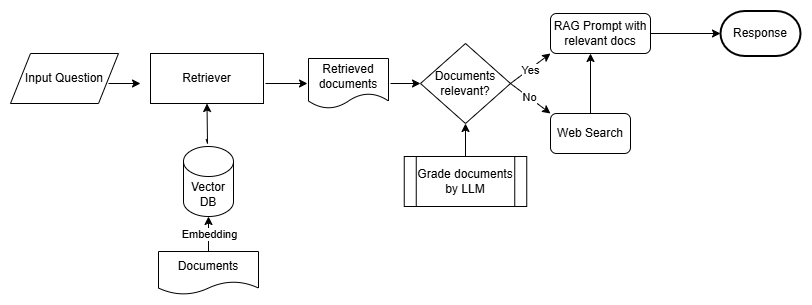

Install required libraries in a conda or venv environment

In [1]:
!pip install --upgrade --quiet  tiktoken scikit-learn gpt4all langchain langchain-community langchain-core langchain_nomic langchain_ollama langgraph 


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In Linux systems, use following commands to install Ollama and download Llama 3.1 model locally.
```
curl -fsSL https://ollama.com/install.sh | sh
ollama run llama3.1
```

In [ ]:
"""
This cell asks you to set up environment variables for a local RAG (Retrieval-Augmented Generation) agent.

Environment Variables:
- USER_AGENT: Specifies the user agent string to be used.
- LANGSMITH_TRACING: Enables or disables tracing for LangChain.
- LANGSMITH_API_KEY: API key for accessing LangChain services.
- TAVILY_API_KEY: API key for accessing Tavily services.
"""
import os

os.environ["USER_AGENT"] = "myagent"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "xxxx"
os.environ["TAVILY_API_KEY"] = "tvly-xxxx"

Use local embedding model to store documents in vector database

In [3]:
"""
This cell performs the following tasks:

1. Imports necessary modules and classes from langchain and related libraries.
2. Defines a list of URLs from IRS to load tax related documents from.
3. Loads documents from the specified URLs using the WebBaseLoader.
4. Flattens the list of loaded documents.
5. Initializes a RecursiveCharacterTextSplitter with a specified chunk size and overlap.
6. Splits the loaded documents into chunks using the text splitter.
7. Initializes an SKLearnVectorStore with the document chunks embedded using  local embeddings model "nomic-embed-text-v1.5" from NomicEmbeddings.
8. Converts the vector store into a retriever with a specified number of nearest neighbors (k=4).

Modules and Classes:
- RecursiveCharacterTextSplitter: Splits text into chunks based on character count.
- WebBaseLoader: Loads documents from web URLs.
- SKLearnVectorStore: Stores document vectors for retrieval.
- NomicEmbeddings: Generates embeddings for documents.
- tool: Utility for defining tools.

Variables:
- urls: List of URLs to load documents from.
- docs: List of loaded documents from the URLs.
- docs_list: Flattened list of loaded documents.
- text_splitter: Instance of RecursiveCharacterTextSplitter.
- doc_splits: List of document chunks.
- vectorstore: Instance of SKLearnVectorStore.
- retriever: Retriever instance for querying the vector store.
"""

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.tools import tool
from langchain_nomic.embeddings import NomicEmbeddings

# List of URLs to load documents from
urls = [
    "https://www.irs.gov/newsroom/irs-releases-tax-inflation-adjustments-for-tax-year-2025",
    "https://www.irs.gov/newsroom/401k-limit-increases-to-23500-for-2025-ira-limit-remains-7000",
    "https://www.irs.gov/newsroom/tax-basics-understanding-the-difference-between-standard-and-itemized-deductions",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using NomicEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(
        model="nomic-embed-text-v1.5", inference_mode="local", device="cpu"
    ),
    # embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [4]:
"""
This cell imports the necessary modules and initializes the web search tool for the LLM.

Modules:
- `Document` from `langchain.schema`: Represents a document schema.
- `TavilySearchResults` from `langchain_community.tools.tavily_search`: Provides functionality to perform web search by LLM if required.

Initialization:
- `web_search_tool`: An instance of `TavilySearchResults` used to perform web searches.
"""
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [5]:
"""
This cell sets up a question-answering assistant using the LangChain library. 
1. It imports necessary modules: `ChatOllama` for the language model, `PromptTemplate` for creating prompts, and `StrOutputParser` for parsing the output.
2. It defines a prompt template that instructs the assistant to answer questions concisely using provided documents.
3. It initializes the `ChatOllama` language model with specific parameters.
4. It creates a chain (`rag_chain`) that combines the prompt template, language model, and output parser to process and generate answers.
This setup is essential for enabling the assistant to handle question-answering tasks effectively.
"""
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

rag_chain = prompt | llm | StrOutputParser()

In [6]:
"""
This cell sets up a prompt template and a retrieval grader for assessing the relevance of a retrieved document to a user question.

Functionality:
- Imports the necessary JsonOutputParser from langchain_core.output_parsers.
- Defines a PromptTemplate that instructs a grader to assess the relevance of a document to a user question.
- The grader uses a simple binary scoring system ('yes' or 'no') to indicate relevance.
- The result is provided as a JSON object with a single key 'score'.
- Combines the prompt template with a language model (llm) and the JsonOutputParser to create the retrieval_grader.

The retrieval_grader can be used in the workflow to filter out erroneous document retrievals based on their relevance to user questions.
"""
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [7]:
# This cell defines the state of the graph and imports necessary modules for graph visualization.
# It includes a TypedDict class `GraphState` that represents the state of the graph with attributes
# such as question, generation, search, documents, and steps. This state will be used to manage
# the workflow of the RAG agent.

from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from typing_extensions import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [8]:
# This cell contains the core functions for the document retrieval and answer generation pipeline.
# The functions are designed to work with a state dictionary that maintains the current state of the process.


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

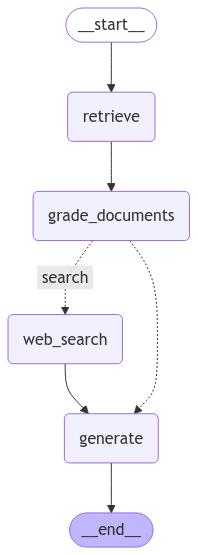

In [11]:
# Graph
"""
This cell defines and builds a state graph workflow for the agent pipeline described earlier.

The workflow consists of the following nodes:
- "retrieve": Retrieves documents from the vector database.
- "grade_documents": Grades the retrieved documents.
- "generate": Generates output based on the graded documents.
- "web_search": Performs a web search if needed.

The workflow is constructed as follows:
1. The entry point is set to the "retrieve" node. so the first step is to retrieve similar documents from the vector database.
2. An edge is added from "retrieve" to "grade_documents".
3. Conditional edges are added from "grade_documents" to either "web_search" or "generate" based on the decision function `decide_to_generate`.
4. An edge is added from "web_search" to "generate".
5. An edge is added from "generate" to the end of the workflow.

Finally, the workflow is compiled into a custom graph and displayed as a Mermaid diagram.
"""
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"search": "web_search", "generate": "generate"},
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
import uuid


def predict_custom_agent_answer(example: dict):
    # This cell defines a function to predict the answer from a custom agent based on the provided example input.
    """
    Predicts the answer from a custom agent based on the provided example input.

    Args:
        example (dict): A dictionary containing the input question under the key "input".

    Returns:
        dict: A dictionary containing the response generated by the custom agent under the key "response",
              and the steps taken during the generation process under the key "steps".

    The `config` dictionary is used to pass configuration settings to the custom graph.
    In this case, it includes a unique `thread_id` generated using `uuid.uuid4()`.
    The `thread_id` ensures that each invocation of the function is uniquely identifiable,
    which can be useful for tracing and debugging purposes.
    """

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

In [13]:
"""
# Here we define an example input question about the difference between standard deduction and itemized deduction,
# and then uses the `predict_custom_agent_answer` function to generate a response based on the input and show it.
# Since, this question is related to tax deductions, the agent should provide an answer based on the loaded tax documents.
"""
example = {
    "input": "What is the difference between standard deduction and itemized deduction?"
}
response = predict_custom_agent_answer(example)
response

{'response': 'The standard deduction is a fixed amount that most taxpayers can claim, while itemized deductions are specific expenses like mortgage interest, charitable donations, and medical expenses that can be deducted from taxable income. Taxpayers choose the option that gives them the lowest overall tax.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [14]:
"""
# Here we define another example input question about the sports event,
# and then uses the `predict_custom_agent_answer` function to generate a response based on the input and show it.
# Since, this question is NOT related to tax deductions, the agent should provide an answer based on the documents returned from web search.
"""
example = {"input": "Who won the 2024 cricket world cup and who was the MVP in final?"}
response = predict_custom_agent_answer(example)
response

{'response': 'India won the 2024 cricket world cup and Virat Kohli was named Player of the Match for. The final match was played between India and South Africa on June 29, 2024. India defeated South Africa by 7 runs to win their second T20 World Cup title.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

As demonstrated in the previous examples, the RAG agent routes the control flow through web search to generate answers for non-TAX related questions. For TAX related queries, it uses documents retrieved from the vector database.